In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from dtree import DT

path = 'C:/Code/UTEC/ML/Project2/tos/cleaned_data/'

np.random.seed(42)

In [3]:
def encode(path):
    positives = []
    positives_directory = os.listdir(path + "Positive")
    print("Loading positives...")
    for f in positives_directory:
        y, sr = librosa.load(path + "Positive/" + f)
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        fv = mfccs.mean(axis=1)
        positives.append(fv)
    positives_array = np.array(positives)
    positives_array = np.insert(positives_array, 0, 1, axis=1)
    print("Loading finished!")

    negatives = []
    negatives_directory = os.listdir(path + "Negative")
    print("Loading negatives...")
    for f in negatives_directory:
        y, sr = librosa.load(path + "Negative/" + f)
        mfccs = librosa.feature.mfcc(y=y, sr=sr)
        fv = mfccs.mean(axis=1)
        negatives.append(fv)
    negatives_array = np.array(negatives)
    negatives_array = np.insert(negatives_array, 0, -1, axis=1)
    print("Loading finished!")

    print("Joining and shuffling loaded data...")
    result_array = np.concatenate((positives_array, negatives_array), axis=0)
    np.random.shuffle(result_array)
    y = result_array[:, 0]
    x = result_array[:, 1:]
    print("Done!")
    return x, y

In [4]:
def matriz_confusion(y_pred, y_test, Tipo):
    matrix = confusion_matrix(y_test, y_pred)
    f2 = pd.DataFrame(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], index=["Negative", 'Positive'],
                      columns=["Negative", 'Positive'])
    sns.heatmap(f2, annot=True, cbar=None, cmap="Greens")
    plt.title("Confusion Matrix" + Tipo), plt.tight_layout()
    plt.xlabel("Predicted")
    plt.ylabel("Real")
    plt.show()

In [5]:
X_data, Y_data = encode(path)
sm = SMOTE(random_state=42)
X_data, Y_data = sm.fit_resample(X_data, Y_data)
x_train, x_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.3)
print(X_data.shape, Y_data.shape)


Loading positives...
Loading finished!
Loading negatives...
Loading finished!
Joining and shuffling loaded data...
Done!
(2414, 20) (2414,)


# Bootstrap

In [70]:
def get_bootstrapped_dataset(x, y):
    rows = x.shape[0]  # n of samples
    indexes = np.random.choice(rows, size=rows, replace=True)
    x_boot = x[indexes]
    y_boot = y[indexes]
    return x_boot, y_boot


def display_results(results):
    iterations = range(results.shape[0])
    plt.plot(iterations, results[:, 0], label='Accuracy', color='red', linewidth=1)
    plt.plot(iterations, results[:, 1], label='Precision', color='blue', linewidth=1)
    plt.plot(iterations, results[:, 2], label='F1 Score', color='green', linewidth=1)
    plt.plot(iterations, results[:, 3], label='Recall', color='purple', linewidth=1)
    plt.title('Bootstrapping Performance Metrics')
    plt.xlabel('Iteration')
    plt.ylabel('Scores')
    plt.legend(loc="lower right")
    plt.show()

# DTree

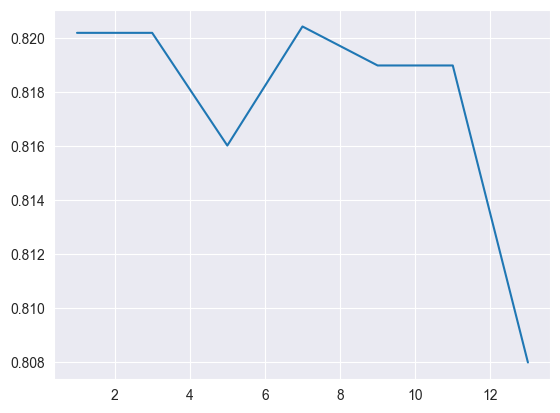

In [7]:
k = [1, 3, 5, 7, 9, 11, 13]
f1_scores_dt = []
for i in k:
    dt = DT(x_train, y_train, min_samples_node=i)
    y_pred = dt.predict(x_test)
    report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"], output_dict=True)
    f1_score = report['weighted avg']['f1-score']
    f1_scores_dt.append(f1_score)

plt.plot(k, f1_scores_dt)




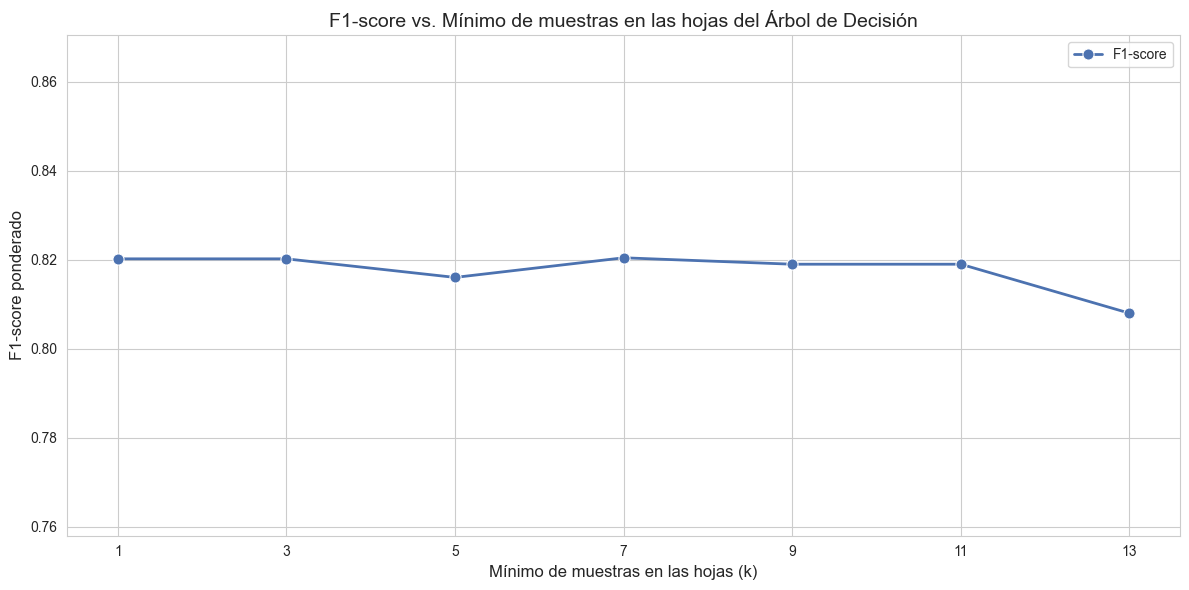

In [9]:
df = pd.DataFrame({'Min samples leaf': k, 'F1-score': f1_scores_dt})

sns.set_style("whitegrid")
sns.set_palette("deep")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Min samples leaf', y='F1-score', marker='o', linewidth=2, markersize=8)

plt.xlabel('Mínimo de muestras en las hojas (k)', fontsize=12)
plt.ylabel('F1-score ponderado', fontsize=12)
plt.title('F1-score vs. Mínimo de muestras en las hojas del Árbol de Decisión', fontsize=14)

plt.legend(['F1-score'], loc='best', fontsize=10)
plt.xticks(k)
plt.ylim(min(f1_scores_dt) - 0.05, max(f1_scores_dt) + 0.05)

# for x, y in zip(k, f1_scores_dt):
#     plt.text(x, y, f'{y:.3f}', ha='center', va='bottom', fontsize=9)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

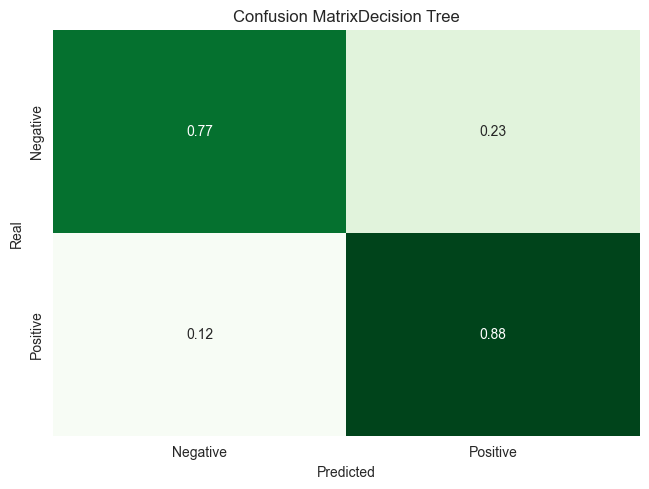

{'Negative': {'precision': 0.8666666666666667, 'recall': 0.7667560321715817, 'f1-score': 0.813655761024182, 'support': 373.0}, 'Positive': {'precision': 0.779746835443038, 'recall': 0.875, 'f1-score': 0.8246318607764391, 'support': 352.0}, 'accuracy': 0.8193103448275862, 'macro avg': {'precision': 0.8232067510548524, 'recall': 0.8208780160857909, 'f1-score': 0.8191438109003106, 'support': 725.0}, 'weighted avg': {'precision': 0.8244655899898153, 'recall': 0.8193103448275862, 'f1-score': 0.8189848466970021, 'support': 725.0}}


In [76]:
dt_2 = DT(x_train, y_train, min_samples_node=11)
y_pred_2 = dt_2.predict(x_test)
matriz_confusion(y_pred_2, y_test, "Decision Tree")
print(classification_report(y_test, y_pred_2, target_names=["Negative", "Positive"], output_dict=True))

Fold 1:
Train Accuracy: 0.9650092081031307
Test Accuracy: 0.8099173553719008
              precision    recall  f1-score   support

    Negative       0.82      0.82      0.82       127
    Positive       0.80      0.80      0.80       115

    accuracy                           0.81       242
   macro avg       0.81      0.81      0.81       242
weighted avg       0.81      0.81      0.81       242

Fold 2:
Train Accuracy: 0.9760589318600368
Test Accuracy: 0.8636363636363636
              precision    recall  f1-score   support

    Negative       0.90      0.83      0.86       125
    Positive       0.83      0.90      0.86       117

    accuracy                           0.86       242
   macro avg       0.86      0.86      0.86       242
weighted avg       0.87      0.86      0.86       242

Fold 3:
Train Accuracy: 0.9668508287292817
Test Accuracy: 0.8264462809917356
              precision    recall  f1-score   support

    Negative       0.83      0.78      0.80       110
    Po

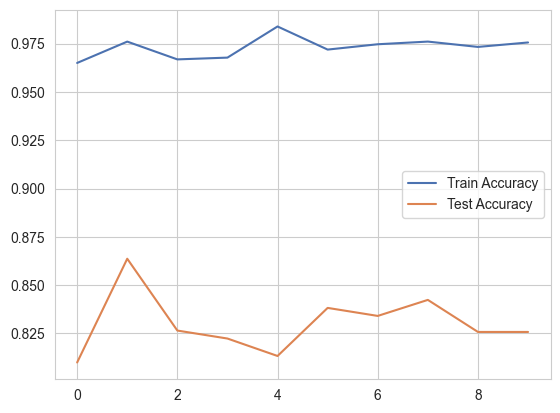

In [72]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

np.random.seed(42)

n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=41)

accuracy_train = []
accuracy_test = []
precision_test = []
recall_test = []
f1_test = []

# Iterar por cada fold
i = 0
for train_index, test_index in kfold.split(X_data, Y_data):
    i += 1
    x_traink, x_testk = X_data[train_index], X_data[test_index]
    y_traink, y_testk = Y_data[train_index], Y_data[test_index]

    model = DT(x_traink, y_traink, min_samples_node=11)

    y_train_pred = model.predict(x_traink)
    y_test_pred = model.predict(x_testk)

    train_accuracy = accuracy_score(y_traink, y_train_pred)
    test_accuracy = accuracy_score(y_testk, y_test_pred)

    accuracy_train.append(train_accuracy)
    accuracy_test.append(test_accuracy)

    print(f"Fold {i}:")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    print(classification_report(y_testk, y_test_pred, target_names=["Negative", "Positive"]))

plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_test, label="Test Accuracy")
plt.legend()
plt.show()


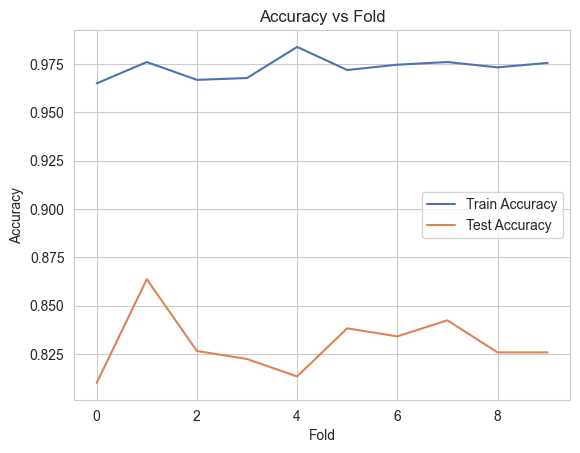

In [73]:
plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_test, label="Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Fold")
plt.title("Accuracy vs Fold")
plt.legend()
plt.show()

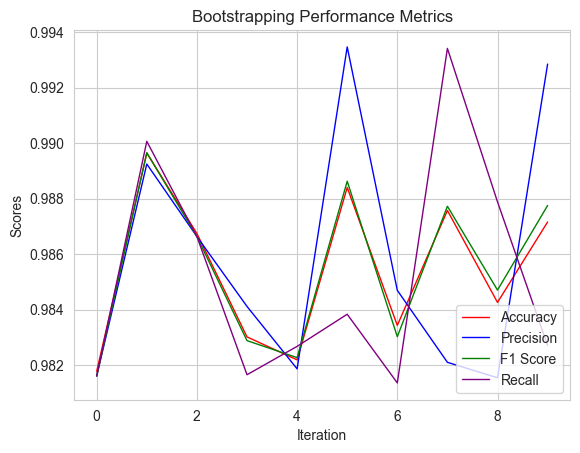

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

iterations = 10

results = np.zeros((iterations, 4))
for i in range(iterations):
    x_boot, y_boot = get_bootstrapped_dataset(X_data, Y_data)
    model = DT(x_boot, y_boot, min_samples_node=11)
    y_pred = model.predict(x_boot)
    acc = accuracy_score(y_boot, y_pred)
    prec = precision_score(y_boot, y_pred)
    f1 = f1_score(y_boot, y_pred)
    rec = recall_score(y_boot, y_pred)
    results[i] = [acc, prec, f1, rec]
display_results(results)

# SVM

In [12]:
import numpy as np


class SVM:
    def __init__(self, c=1e8, alpha=1e-10, epochs=39000):
        self.c = c
        self.alpha = alpha
        self.epochs = epochs
        self.w = None
        self.b = None
        self.error = []

    def normalize(self, data):
        min = np.min(data, axis=0)
        max = np.max(data, axis=0)
        return (data - min) / (max - min)

    def h(self, x):
        return np.dot(x, self.w.T) + self.b

    def loss(self, y, y_aprox):
        return 1 / 2 * np.linalg.norm(self.w) ** 2 + self.c * np.sum(np.maximum(0, 1 - y * y_aprox))

    def derivatives(self, x, y, y_aprox):
        n = x.shape[0]
        dw = np.zeros(self.w.shape)
        db = 0.0

        for i in range(n):
            if (y[i] * y_aprox[i]) < 1:
                dw += self.c * -y[i] * x[i]
                db += self.c * -y[i]
        dw += self.w

        return dw, db

    def update(self, x, y, y_aprox, dw, db):
        n = x.shape[0]

        for i in range(n):
            if y[i] * y_aprox[i] < 1:
                self.w -= self.alpha * dw
                self.b -= self.alpha * db
            else:
                self.w -= self.alpha * self.w

    def train(self, x, y):
        x = self.normalize(x)
        self.w = np.array([np.random.rand() for _ in range(x.shape[1])])
        self.b = np.random.rand()

        for _ in range(self.epochs):
            y_aprox = self.h(x)
            dw, db = self.derivatives(x, y, y_aprox)
            self.update(x, y, y_aprox, dw, db)
            L = self.loss(y, y_aprox)
            self.error.append(L)
        return self.w, self.b, self.error

    def polynomial(self, x_ind, x, c, n):
        return (np.dot(x_ind, x) + c) ** n

    def predict(self, x):
        x = self.normalize(x)
        y_aprox = []
        for i in range(x.shape[0]):
            y_aprox.append(np.sign(np.dot(x[i], self.w.transpose()) + self.b))
        return np.array(y_aprox)

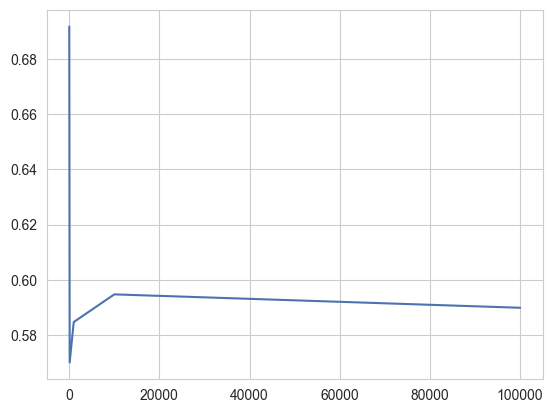

In [62]:
# 62 78, 1e5, 1e-8, 10000
np.random.seed(42)
# model = SVM(1e5, 1e-8, 10000)
# model = SVM(1e3, 1e-11, 15000)
lambdas = [1e1, 1e2, 1e3, 1e4, 1e5]
f1_score_svm = []
for l in lambdas:
    model = SVM(l, 1e-8, 10000)
    model.train(x_train, y_train)
    y_pred = model.predict(x_test)
    report = classification_report(y_test, y_pred, target_names=["Negative", "Positive"], output_dict=True)
    f1_score = report['weighted avg']['f1-score']
    f1_score_svm.append(f1_score)

plt.plot(lambdas, f1_score_svm)



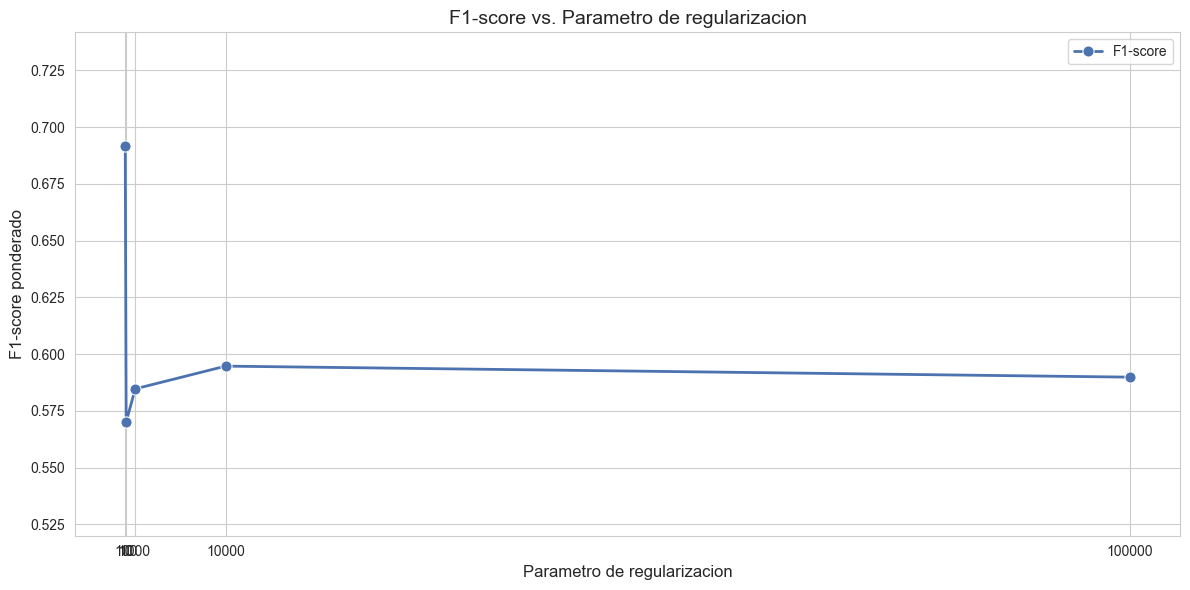

In [66]:
df = pd.DataFrame({'Parametro de regularizacion': lambdas, 'F1-score': f1_score_svm})

sns.set_style("whitegrid")
sns.set_palette("deep")

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Parametro de regularizacion', y='F1-score', marker='o', linewidth=2, markersize=8)

plt.xlabel('Parametro de regularizacion', fontsize=12)
plt.ylabel('F1-score ponderado', fontsize=12)
plt.title('F1-score vs. Parametro de regularizacion', fontsize=14)

plt.legend(['F1-score'], loc='best', fontsize=10)
plt.xticks(lambdas)
plt.ylim(min(f1_score_svm) - 0.05, max(f1_score_svm) + 0.05)

plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

    Negative       0.69      0.74      0.71       373
    Positive       0.70      0.64      0.67       352

    accuracy                           0.70       725
   macro avg       0.70      0.69      0.69       725
weighted avg       0.70      0.70      0.69       725



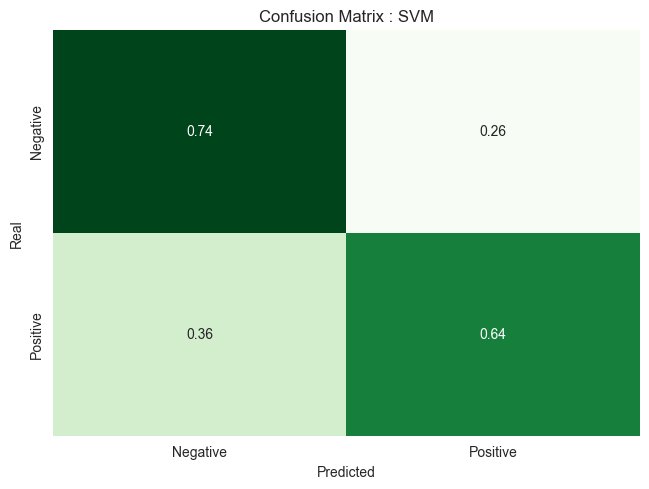

In [69]:
model1 = SVM(1e1, 1e-8, 10000)
model1.train(x_train, y_train)
y_pred1 = model1.predict(x_test)
print(classification_report(y_test, y_pred1, target_names=["Negative", "Positive"]))
matriz_confusion(y_pred1, y_test, " : SVM")


Fold 1:
Train Accuracy: 0.6979742173112339
Test Accuracy: 0.6942148760330579
              precision    recall  f1-score   support

    Negative       0.65      0.90      0.75       127
    Positive       0.81      0.47      0.59       115

    accuracy                           0.69       242
   macro avg       0.73      0.68      0.67       242
weighted avg       0.72      0.69      0.68       242

Fold 2:
Train Accuracy: 0.7007366482504604
Test Accuracy: 0.6776859504132231
              precision    recall  f1-score   support

    Negative       0.71      0.63      0.67       125
    Positive       0.65      0.73      0.69       117

    accuracy                           0.68       242
   macro avg       0.68      0.68      0.68       242
weighted avg       0.68      0.68      0.68       242

Fold 3:
Train Accuracy: 0.7030386740331491
Test Accuracy: 0.5537190082644629
              precision    recall  f1-score   support

    Negative       0.51      0.85      0.64       110
    Po

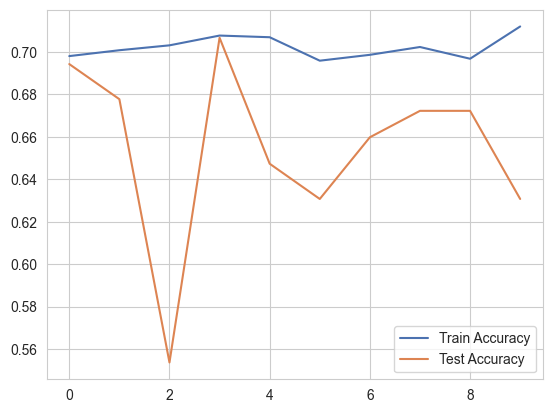

In [67]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

np.random.seed(42)

n_folds = 10
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=41)

accuracy_train = []
accuracy_test = []
precision_test = []
recall_test = []
f1_test = []

# Iterar por cada fold
i = 0
for train_index, test_index in kfold.split(X_data, Y_data):
    i += 1
    x_traink, x_testk = X_data[train_index], X_data[test_index]
    y_traink, y_testk = Y_data[train_index], Y_data[test_index]

    model = SVM(1e1, 1e-8, 10000)

    model.train(x_traink, y_traink)

    y_train_pred = model.predict(x_traink)
    y_test_pred = model.predict(x_testk)

    train_accuracy = accuracy_score(y_traink, y_train_pred)
    test_accuracy = accuracy_score(y_testk, y_test_pred)

    accuracy_train.append(train_accuracy)
    accuracy_test.append(test_accuracy)

    print(f"Fold {i}:")
    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}")

    print(classification_report(y_testk, y_test_pred, target_names=["Negative", "Positive"]))




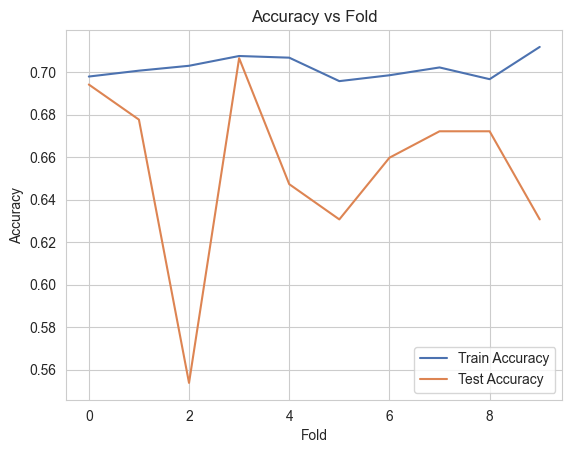

In [68]:
plt.plot(accuracy_train, label="Train Accuracy")
plt.plot(accuracy_test, label="Test Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Fold")
plt.title("Accuracy vs Fold")
plt.legend()
plt.show()

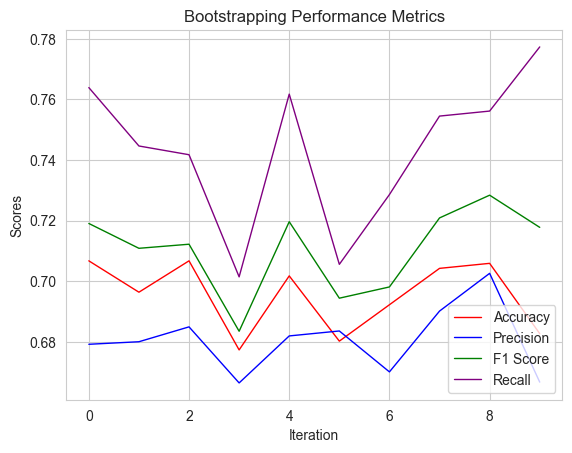

In [71]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

iterations = 10
model = SVM(1e1, 1e-8, 10000)
results = np.zeros((iterations, 4))
for i in range(iterations):
    x_boot, y_boot = get_bootstrapped_dataset(X_data, Y_data)
    model.train(x_boot, y_boot)
    y_pred = model.predict(x_boot)
    acc = accuracy_score(y_boot, y_pred)
    prec = precision_score(y_boot, y_pred)
    f1 = f1_score(y_boot, y_pred)
    rec = recall_score(y_boot, y_pred)
    results[i] = [acc, prec, f1, rec]
display_results(results)